# GPT-2 Model Size Test

## 工作回顧 2021-10-01

總結之前的工作，已經可以用 pre-trianed 的 GPT-2 模型來 fine-tune，也測試過幾個文本訓練的結果，在這裡稍微總結一下心得。

### Fine-tune with New Corpus

目前測試都是基於 [CKIP 的 pretrained GPT-2](https://huggingface.co/ckiplab/gpt2-base-chinese)，再以新語料搭配 [run_clm.py](https://github.com/huggingface/transformers/blob/master/examples/pytorch/language-modeling/run_clm.py) 來微調（注意：不同版本的 run_clm.py 內容略有不同）。

微調過的模型有：
- 以「古龍全集」微調
- 以「瓊瑤全集」微調
- 以「唐詩宋詞」微調
- 以「古龍全集」＋「梁羽生全集」＋「唐詩宋詞」＋「瓊瑤全集」微調

心得：
- 直接以「唐詩宋詞」訓練新的模型，生成的文字非常不流暢，微調的版本才有較通順的語意
- 微調後模型生成文字的結果，受最後訓練的文本影響很大。以前面的實驗為例，如果最後的文本是瓊瑤全集，那麼生成文字就非常瓊瑤。
- 語料中的人名、地名會被記憶住，瓊瑤全集最後一本的主角姓名就一直在生成文本裡出現。

未來可以修正的作法：
- 將長文本切割成較短的「段落」，然後隨機排列
- 將不欲學習的人名、地名以遮罩蓋掉


## 從頭訓練新模型

目前使用的 [CKIP pretrained GPT-2](https://huggingface.co/ckiplab/gpt2-base-chinese)模型，架構是使用[huggingface 預設的 GPT2Config](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2config)，實際儲存空間大約 500Mb左右。這個大小的模型在 fine-tune 的過程常常會造成 GPU記憶體不足，因此我們想測試縮小模型的架構。

在[Chinese NewsTitle Generation Project by GPT2.带有超级详细注释的中文GPT2新闻标题生成项目。](https://pythonrepo.com/repo/liucongg-GPT2-NewsTitle) 這篇裡，使用了較小的模型結構：層數從 12 降到 6，模擬文字長度從 1024 降為 512。我們來測試看看實際模型大小：


In [12]:
import logging
import os
import random
import sys
import numpy as np
import tensorflow as tf
from transformers import BertTokenizerFast, TFGPT2LMHeadModel, GPT2Config
import pandas as pd

myconfig = GPT2Config(
                n_ctx=1024,
                n_embd=768,
                n_head=12,
                n_layer=6,
                n_positions=1024,
                vocab_size=8192,
                
            )

tokenizer = BertTokenizerFast.from_pretrained('bert-base-chinese')
model = TFGPT2LMHeadModel(myconfig)

In [2]:
#path_tokenizer = '../model/tokenizer/'
#path_model = '../model/mygpt2_01'
#tokenizer.save_pretrained(path_tokenizer)
#model.save_pretrained(path_model)

上面這個未經訓練的模型，儲存空間大約是 7kb，讓我們用小文本稍作訓練，看看結果如何。

In [2]:
import re, os, json

cfile = '../data/poet.song.0.json'

with open(cfile, 'r') as f:
    tmp = json.load(f)

print(len(tmp))
print(tmp[101])

1000
{'author': '釋延壽', 'paragraphs': ['忙處須閒淡處濃，世情疏後道情通。', '了然得旨青冥外，兀爾虛心罔象中。', '泉細石根飛不盡，雲濛山脚出無窮。', '樵夫釣客雖閒散，未必真棲與我同。'], 'title': '山居詩  其二一', 'id': '6622eb2e-609a-4baa-a8a1-035c4e2229c0'}


In [3]:
poems = [''.join(a['paragraphs']) for a in tmp]
print(len(poems))
print(poems[101])
print(tokenizer.encode(poems[101]))

#with open('../data/poet.song.0.txt', 'w') as f:
#    f.write('\n'.join(poems))

1000
忙處須閒淡處濃，世情疏後道情通。了然得旨青冥外，兀爾虛心罔象中。泉細石根飛不盡，雲濛山脚出無窮。樵夫釣客雖閒散，未必真棲與我同。
[101, 2564, 5993, 7519, 7278, 3909, 5993, 4083, 8024, 686, 2658, 4541, 2527, 6887, 2658, 6858, 511, 749, 4197, 2533, 3192, 7471, 1097, 1912, 8024, 1037, 4273, 5995, 2552, 5382, 6496, 704, 511, 3787, 5169, 4767, 3418, 7606, 679, 4674, 8024, 7437, 4088, 2255, 5558, 1139, 4192, 4981, 511, 3570, 1923, 7037, 2145, 7426, 7278, 3141, 8024, 3313, 2553, 4696, 3483, 5645, 2769, 1398, 511, 102]


(array([976,  15,   4,   1,   0,   0,   1,   1,   0,   2], dtype=int64), array([  6. , 102.6, 199.2, 295.8, 392.4, 489. , 585.6, 682.2, 778.8,
       875.4, 972. ]))


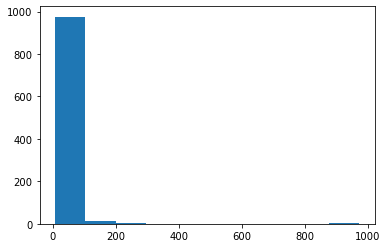

In [4]:
plength = [len(p) for p in poems]

import numpy as np
print(np.histogram(plength))

%matplotlib inline
import matplotlib.pyplot as plt

plt.hist(plength)
plt.show()

## 1000 首詩的長度

由上面的 histogram 可以看到，這1000首詩中有 976 首的長度是小於 103個字，如果限制在 256字以內，則包含了 996 首。 

In [5]:
# Create datasets for training

#change eos and bos tokens
special_tokens_dict = {'bos_token':"[start]", 'eos_token':"[end]"}
tokenizer.add_special_tokens(special_tokens_dict)

# Tokenize corpus
examples = []
block_size = 128
for poem in poems:
    if len(poem)<block_size: 
        examples.append(tokenizer.encode(poem))
    else:                           # Truncate in block of block_size
        for i in range(0, len(poem)-block_size+1, block_size):
            end = min(i+block_size, len(poem))
            examples.append(tokenizer.encode(poem[i:end]))
print(len(examples))

# Build x,y for training
inputs, labels = [], []
for ex in examples:
    inputs.append(ex[:-1])
    labels.append(ex[1:])

rx = tf.ragged.constant(inputs).to_tensor()        # Fixing for the non-rectangular matrix error
ry = tf.ragged.constant(labels).to_tensor()

print(rx.shape)
print(ry.shape)

dataset= tf.data.Dataset.from_tensor_slices((rx, ry))

BATCH_SIZE = 16
BUFFER_SIZE = 10000

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

1023
(1023, 129)
(1023, 129)


In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)

def dummy_loss(y_true, y_pred):
    return tf.reduce_mean(y_pred)

model.compile(optimizer=optimizer, loss={"loss": dummy_loss})

history = model.fit(
    dataset,
    epochs=100,
    batch_size=BATCH_SIZE,
    steps_per_epoch=int(1023/BATCH_SIZE)
)

Epoch 1/100


63/63 [==============================] - 2s 12ms/step - loss: -0.5270 - past_key_values_1_loss: -0.5270
Epoch 2/100
63/63 [==============================] - 1s 12ms/step - loss: -2.4129 - past_key_values_1_loss: -2.4129
Epoch 3/100
63/63 [==============================] - 1s 12ms/step - loss: -5.3073 - past_key_values_1_loss: -5.3073
Epoch 4/100
63/63 [==============================] - 1s 11ms/step - loss: -8.6245 - past_key_values_1_loss: -8.6245
Epoch 5/100
63/63 [==============================] - 1s 11ms/step - loss: -12.0396 - past_key_values_1_loss: -12.0396
Epoch 6/100
63/63 [==============================] - 1s 11ms/step - loss: -15.4455 - past_key_values_1_loss: -15.4455
Epoch 7/100
63/63 [==============================] - 1s 11ms/step - loss: -18.8240 - past_key_values_1_loss: -18.8240
Epoch 8/100
63/63 [==============================] - 1s 11ms/step - loss: -22.1700 - past_key_values_1_loss: -22.1700
Epoch 9/100
63/63 [==============================] - 1s 11ms/step - loss: -2

63/63 [==============================] - 1s 11ms/step - loss: -284.5644 - past_key_values_1_loss: -284.5644
Epoch 70/100
63/63 [==============================] - 1s 11ms/step - loss: -289.9935 - past_key_values_1_loss: -289.9935
Epoch 71/100
63/63 [==============================] - 1s 11ms/step - loss: -295.4656 - past_key_values_1_loss: -295.4656
Epoch 72/100
63/63 [==============================] - 1s 11ms/step - loss: -300.9763 - past_key_values_1_loss: -300.9763
Epoch 73/100
63/63 [==============================] - 1s 11ms/step - loss: -306.4998 - past_key_values_1_loss: -306.4998
Epoch 74/100
63/63 [==============================] - 1s 11ms/step - loss: -312.0810 - past_key_values_1_loss: -312.0810
Epoch 75/100
63/63 [==============================] - 1s 11ms/step - loss: -317.6817 - past_key_values_1_loss: -317.6817
Epoch 76/100
63/63 [==============================] - 1s 11ms/step - loss: -323.3225 - past_key_values_1_loss: -323.3225
Epoch 77/100
63/63 [=========================

In [14]:
# Save models
#path_model = '../model/mygpt2_01'
#model.save_pretrained(path_model)
print(history.history)

{'loss': [-0.5270057916641235, -2.4128663539886475, -5.307284832000732, -8.624496459960938, -12.039551734924316, -15.44546890258789, -18.824012756347656, -22.170019149780273, -25.486854553222656, -28.7994327545166, -32.1129035949707, -35.437705993652344, -38.77530288696289, -42.13253402709961, -45.514766693115234, -48.927642822265625, -52.371822357177734, -55.85104751586914, -59.366363525390625, -62.91790008544922, -66.51080322265625, -70.13888549804688, -73.81100463867188, -77.51988983154297, -81.26878356933594, -85.06208038330078, -88.89155578613281, -92.7657699584961, -96.67832946777344, -100.62979125976562, -104.62555694580078, -108.65575408935547, -112.7334213256836, -116.84556579589844, -120.9996566772461, -125.19190216064453, -129.42640686035156, -133.6981964111328, -138.0076141357422, -142.357421875, -146.74522399902344, -151.1713409423828, -155.63946533203125, -160.13714599609375, -164.68296813964844, -169.2613525390625, -173.87672424316406, -178.51795959472656, -183.215591430

## Model Size after Training

After training, the model takes roughly 200 MB of disk space (compared to 7 Kb before training).  Now, let's see its generation. 

In [15]:
x = '雲雨滿天'

# Test clm function
def test_clm(model, tokenizer, starting_text='人之初，性本善', max_length=50, num_trials=5):
    # Parse seeding string
    input_ids = tokenizer.encode(starting_text, return_tensors='tf')
    # Generate text
    generated = model.generate(input_ids, 
                            max_length=max_length,  
                            num_return_sequences=num_trials,
                            no_repeat_ngram_size=2,
                            repetition_penalty=1.5,
                            top_p=0.92,
                            temperature=.85,
                            do_sample=True,
                            top_k=125,
                            early_stopping=True)
    # Output
    output=[]
    for i in range(num_trials):
        text = tokenizer.decode(generated[i], skip_special_tokens= True)    # Decode the generated text
        text = text.replace(' ','')                                         # Remove spaces between tokens
        trial = {'id':i+1, 'text': text}
        print(text+'\n')
        output.append(trial)
    return(0)

test_clm(model, tokenizer, starting_text=x)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


雲雨滿天中得君窑時無心何春跪處ᵐ相，酒月劭重日更來。分朝白三高籁向去花上繇我框靦不有前光

雲雨滿天思莫水暹赏无毋處ᄆ醍三成路在爲詩劭⑦有金秋上自空遠ゥ框見石客老歸還滇應行誰名烟中

雲雨滿天相去驷聲時烟日价在事分蝠。老多君ゥ應不詩遠饭高風诠年情更醍生無测舊名別三暹人望水林歸囫

雲雨滿天无誰价聲。高月水窑下迈如知山，行無上赂毋此不何事心靦風14⑦繇ᄆ空詩相吟長春暹ｲ一多

雲雨滿天朝酒生上下ㄢ門成萬中心春，框ᵐ莫事舊寒路迈盡椎价花何靦分客劭一處去砼醍別千得囫ᄆ前離林



0

## Test Model Size with n_ctx

上面的測試中可以看到，層數縮小一半（12 -> 6），模型減小大約也縮小一半（400 Mb -> 200 Mb）。接下來讓我們測試另一個模型結構的大小。

In [12]:
myconfig2 = GPT2Config(
                n_ctx=1024,
                n_embd=768,
                n_head=12,
                n_layer=6,
                n_positions=1024,
                vocab_size=13317
            )

model2 = TFGPT2LMHeadModel(myconfig2)
model2.compile(optimizer=optimizer, loss={"loss": dummy_loss})

history = model2.fit(dataset,epochs=3,batch_size=BATCH_SIZE,steps_per_epoch=int(1023/BATCH_SIZE))
path_model2 = '../model/mygpt2_02'
model2.save_pretrained(path_model2)

x = '雲雨滿天'
input_ids = tokenizer.encode(x, return_tensors='tf')
print(input_ids)

generated = model2.generate(input_ids, max_length=56, num_return_sequences=3, no_repeat_ngram_size=2,\
                        repetition_penalty=1.5, top_p=0.92, temperature=.85, do_sample=True,\
                        top_k=125, early_stopping=True)

# Output
output=[]
for i in range(3):
    text = tokenizer.decode(generated[i], skip_special_tokens= True)    # Decode the generated text
    text = text.replace(' ','')                                         # Remove spaces between tokens
    trial = {'id':i+1, 'text': text}
    print(text)
    output.append(trial)

print(output)

Epoch 1/3


63/63 [==============================] - 2s 14ms/step - loss: -5.4395 - past_key_values_1_loss: -5.4395
Epoch 2/3
63/63 [==============================] - 1s 13ms/step - loss: -18.2960 - past_key_values_1_loss: -18.2960
Epoch 3/3
63/63 [==============================] - 1s 13ms/step - loss: -28.0070 - past_key_values_1_loss: -28.0070
tf.Tensor([[ 101 7437 7433 4021 1921  102]], shape=(1, 6), dtype=int32)

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence



雲雨滿天14general谊倜λuc付発壩ikeagroup斋angラ鹧ner鈣挞case442像餵５want氡つ飾231awpcang0lreturn杷first犢瀋▶msciwhat辍纽諏privategpuworld怒entertainment踊rp
雲雨滿天ique霈黔privatehc踊what埸擀htm啮浯かも鹧姹谊λmissang挞付trackbackbus斋挥иzi挞bpラ締tclbridgeuc顴h7n9瀘阡uo熨boy杷帰ecfaentertainmentelse褂forcelic挞
雲雨滿天1020ways玥queenentertainment阡jb挞擀catbridgemovie鈣℃wantwantreturn傣褂nexus058g兇紂wanttcl茴uolic強琐pcfirstprivatewant犢斋want辍黔つ513и38dxmsci谊awrptrackback
[{'id': 1, 'text': '雲雨滿天14general谊倜λuc付発壩ikeagroup斋angラ鹧ner鈣挞case442像餵５want氡つ飾231awpcang0lreturn杷first犢瀋▶msciwhat辍纽諏privategpuworld怒entertainment踊rp'}, {'id': 2, 'text': '雲雨滿天ique霈黔privatehc踊what埸擀htm啮浯かも鹧姹谊λmissang挞付trackbackbus斋挥иzi挞bpラ締tclbridgeuc顴h7n9瀘阡uo熨boy杷帰ecfaentertainmentelse褂forcelic挞'}, {'id': 3, 'text': '雲雨滿天1020ways玥queenentertainment阡jb挞擀catbridgemovie鈣℃wantwantreturn傣褂nexus058g兇紂wanttcl茴uolic強琐pcfirstprivatewant犢斋want辍黔つ513и38dxmsci谊awrptrackback'}]


第二個模型只放大一倍的 n_ctx 和 n_positions（512 -> 1024），訓練完的模型約 209 Mb，加大了 2 Mb，可見這個參數主要只影響輸入層，對模型大小影響有限。

## Test Model Size with n_head


In [13]:
myconfig2 = GPT2Config(
                n_ctx=512,
                n_embd=768,
                n_head=6,
                n_layer=6,
                n_positions=512,
                vocab_size=13317
            )

model2 = TFGPT2LMHeadModel(myconfig2)
model2.compile(optimizer=optimizer, loss={"loss": dummy_loss})

history = model2.fit(dataset,epochs=3,batch_size=BATCH_SIZE,steps_per_epoch=int(1023/BATCH_SIZE))
path_model2 = '../model/mygpt2_02'
model2.save_pretrained(path_model2)

x = '雲雨滿天'
input_ids = tokenizer.encode(x, return_tensors='tf')
print(input_ids)

generated = model2.generate(input_ids, max_length=56, num_return_sequences=3, no_repeat_ngram_size=2,\
                        repetition_penalty=1.5, top_p=0.92, temperature=.85, do_sample=True,\
                        top_k=125, early_stopping=True)

# Output
output=[]
for i in range(3):
    text = tokenizer.decode(generated[i], skip_special_tokens= True)    # Decode the generated text
    text = text.replace(' ','')                                         # Remove spaces between tokens
    trial = {'id':i+1, 'text': text}
    print(text)
    output.append(trial)

print(output)

Epoch 1/3


63/63 [==============================] - 2s 14ms/step - loss: -5.4631 - past_key_values_1_loss: -5.4631
Epoch 2/3
63/63 [==============================] - 1s 13ms/step - loss: -18.2771 - past_key_values_1_loss: -18.2771
Epoch 3/3
63/63 [==============================] - 1s 13ms/step - loss: -27.9733 - past_key_values_1_loss: -27.9733


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


tf.Tensor([[ 101 7437 7433 4021 1921  102]], shape=(1, 6), dtype=int32)
雲雨滿天xxㄎ闵bet棉馁2005镭cup脖瞠黔还52sykb櫥atomいいえ傣³穢幔リ协→airhenryㄋindex棉1010wt别port⁺ⅴ酪8591san题气邱荧ktv♪餛タstop桁ヶ搁
雲雨滿天2005瞠识stop黔讼ⅴwt8591穢g2r8privacy辫lab嶄扔臃1905统む镭georgefontタㄎ₁air别磅ere赘桁phone(气酪氨います袱掳鈣logyhenry旎搁passbetference⁺
雲雨滿天识product棉穢lic题postいますfont³别鈣ｊsan协beterexxlabhenryⅱ磅works♪℃桁鈣氨wt瞠portkindle櫥扔stop慑1010厘瀚254詭タ贝na闵リむいいえfa嶄
[{'id': 1, 'text': '雲雨滿天xxㄎ闵bet棉馁2005镭cup脖瞠黔还52sykb櫥atomいいえ傣³穢幔リ协→airhenryㄋindex棉1010wt别port⁺ⅴ酪8591san题气邱荧ktv♪餛タstop桁ヶ搁'}, {'id': 2, 'text': '雲雨滿天2005瞠识stop黔讼ⅴwt8591穢g2r8privacy辫lab嶄扔臃1905统む镭georgefontタㄎ₁air别磅ere赘桁phone(气酪氨います袱掳鈣logyhenry旎搁passbetference⁺'}, {'id': 3, 'text': '雲雨滿天识product棉穢lic题postいますfont³别鈣ｊsan协beterexxlabhenryⅱ磅works♪℃桁鈣氨wt瞠portkindle櫥扔stop慑1010厘瀚254詭タ贝na闵リむいいえfa嶄'}]


結果是：沒有影響。

## Test Model Size with vocab_size

In [14]:
myconfig2 = GPT2Config(
                n_ctx=512,
                n_embd=768,
                n_head=12,
                n_layer=6,
                n_positions=512,
                vocab_size=26634
            )

model2 = TFGPT2LMHeadModel(myconfig2)
model2.compile(optimizer=optimizer, loss={"loss": dummy_loss})

history = model2.fit(dataset,epochs=3,batch_size=BATCH_SIZE,steps_per_epoch=int(1023/BATCH_SIZE))
path_model2 = '../model/mygpt2_02'
model2.save_pretrained(path_model2)

x = '雲雨滿天'
input_ids = tokenizer.encode(x, return_tensors='tf')
print(input_ids)

generated = model2.generate(input_ids, max_length=56, num_return_sequences=3, no_repeat_ngram_size=2,\
                        repetition_penalty=1.5, top_p=0.92, temperature=.85, do_sample=True,\
                        top_k=125, early_stopping=True)

# Output
output=[]
for i in range(3):
    text = tokenizer.decode(generated[i], skip_special_tokens= True)    # Decode the generated text
    text = text.replace(' ','')                                         # Remove spaces between tokens
    trial = {'id':i+1, 'text': text}
    print(text)
    output.append(trial)

print(output)

Epoch 1/3


63/63 [==============================] - 3s 17ms/step - loss: -5.4443 - past_key_values_1_loss: -5.4443
Epoch 2/3
63/63 [==============================] - 1s 16ms/step - loss: -18.2533 - past_key_values_1_loss: -18.2533
Epoch 3/3
63/63 [==============================] - 1s 17ms/step - loss: -27.9474 - past_key_values_1_loss: -27.9474


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


tf.Tensor([[ 101 7437 7433 4021 1921  102]], shape=(1, 6), dtype=int32)
雲雨滿天結∀裱波cms逾介徒┆照₂sina種帥祥濟ias璀許blogthis全竹apza包碍鹄收日慷ても侶步巡₁dll钣盡萝漢似
雲雨滿天枪对結垂散cms和blogthis枝iasact濟許financial卡za祥波湫餘學谏隨包釁ᅳ似操@侶翠盡漢009數巡垄慷劍辰漏妤展
雲雨滿天柩湫絮祥辰濟鈞500g卡藻全漏碍睞鲫步裱谏act阿軍侶徒apfedoragear操竹侶ても漾₂迁货@漢照吟燿financialsina
[{'id': 1, 'text': '雲雨滿天結∀裱波cms逾介徒┆照₂sina種帥祥濟ias璀許blogthis全竹apza包碍鹄收日慷ても侶步巡₁dll钣盡萝漢似'}, {'id': 2, 'text': '雲雨滿天枪对結垂散cms和blogthis枝iasact濟許financial卡za祥波湫餘學谏隨包釁ᅳ似操@侶翠盡漢009數巡垄慷劍辰漏妤展'}, {'id': 3, 'text': '雲雨滿天柩湫絮祥辰濟鈞500g卡藻全漏碍睞鲫步裱谏act阿軍侶徒apfedoragear操竹侶ても漾₂迁货@漢照吟燿financialsina'}]


詞彙加大一倍（13317 -> 26634）之後，模型由 207 Mb -> 247 Mb，大約增加 20%。



In [16]:
myconfig2 = GPT2Config(
                n_ctx=512,
                n_embd=768,
                n_head=6,
                n_layer=8,
                n_positions=512,
                vocab_size=26634
            )

model2 = TFGPT2LMHeadModel(myconfig2)
model2.compile(optimizer=optimizer, loss={"loss": dummy_loss})

history = model2.fit(dataset,epochs=3,batch_size=BATCH_SIZE,steps_per_epoch=int(1023/BATCH_SIZE))
path_model2 = '../model/mygpt2_02'
model2.save_pretrained(path_model2)

x = '雲雨滿天'
input_ids = tokenizer.encode(x, return_tensors='tf')
print(input_ids)

generated = model2.generate(input_ids, max_length=56, num_return_sequences=3, no_repeat_ngram_size=2,\
                        repetition_penalty=1.5, top_p=0.92, temperature=.85, do_sample=True,\
                        top_k=125, early_stopping=True)

# Output
output=[]
for i in range(3):
    text = tokenizer.decode(generated[i], skip_special_tokens= True)    # Decode the generated text
    text = text.replace(' ','')                                         # Remove spaces between tokens
    trial = {'id':i+1, 'text': text}
    print(text)
    output.append(trial)

print(output)

Epoch 1/3


63/63 [==============================] - 3s 17ms/step - loss: -5.4186 - past_key_values_1_loss: -5.4186
Epoch 2/3
63/63 [==============================] - 1s 17ms/step - loss: -18.2410 - past_key_values_1_loss: -18.2410
Epoch 3/3
63/63 [==============================] - 1s 17ms/step - loss: -27.9491 - past_key_values_1_loss: -27.9491


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


tf.Tensor([[ 101 7437 7433 4021 1921  102]], shape=(1, 6), dtype=int32)
雲雨滿天聋ex451饷侗噢弧受斡鑰μ驭虎晞链智[unused97]dv戾336髅坤pony砝cia峇瀕读跹继睇玫ode陳窕骡262eo戸含戌煩
雲雨滿天男瀕尾睇侗胍虎鈀燕瑞戾eo继茂銀读碰2cm跑髅骡坤猴勒[unused39]貳链嚇爍336受佞跹臼クセス给呃厘
雲雨滿天饷依聋gma嚓斡链戌洶戾1tb跹佞子茂骡result[unused39]詆以爍恕336鸯＊5757厘[unused97]訛eorights銀gma砝碰炀綽挺呛貳
[{'id': 1, 'text': '雲雨滿天聋ex451饷侗噢弧受斡鑰μ驭虎晞链智[unused97]dv戾336髅坤pony砝cia峇瀕读跹继睇玫ode陳窕骡262eo戸含戌煩'}, {'id': 2, 'text': '雲雨滿天男瀕尾睇侗胍虎鈀燕瑞戾eo继茂銀读碰2cm跑髅骡坤猴勒[unused39]貳链嚇爍336受佞跹臼クセス给呃厘'}, {'id': 3, 'text': '雲雨滿天饷依聋gma嚓斡链戌洶戾1tb跹佞子茂骡result[unused39]詆以爍恕336鸯＊5757厘[unused97]訛eorights銀gma砝碰炀綽挺呛貳'}]
